<h1><center>RiDS: A Lightweight Link Flooding Attack Mitigation Algorithm for Inter-Satellite Networks</center></h1>
<h2><center><i>Dissertation Graphs</i></center></h2>

### Images and log directories


In [14]:
LOG_DIRECTORY = "simulator/Logs/"
IMAGE_DIRECTORY = "images/"

# 4.2. Design

## 4.2.2. Configuring $i_\text{max}$

Let:
- the maximum capacity of a link be $20$ Gbps
- the traffic per malicious route be $4$ Gbps.
- $1 \leq i_\text{max} \leq 20$
- $5 \leq K \leq 60$

Recall that a malicious route is considered **successful** if it travels through the target link.
The attacker therefore needs $5$ successes for a successful LFA.

In [15]:
# Libraries
import numpy as np
from scipy.stats import nbinom
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from matplotlib.ticker import MaxNLocator
from scipy.stats import binom
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Global params
matplotlib.rcParams["font.size"] = 13
sns.set_style("darkgrid")

### Probability of Congestion per Snapshot
We compute the probability of a successful LFA $P[A \leq K]$ after at most $K$ trials against $i_\text{max}$.

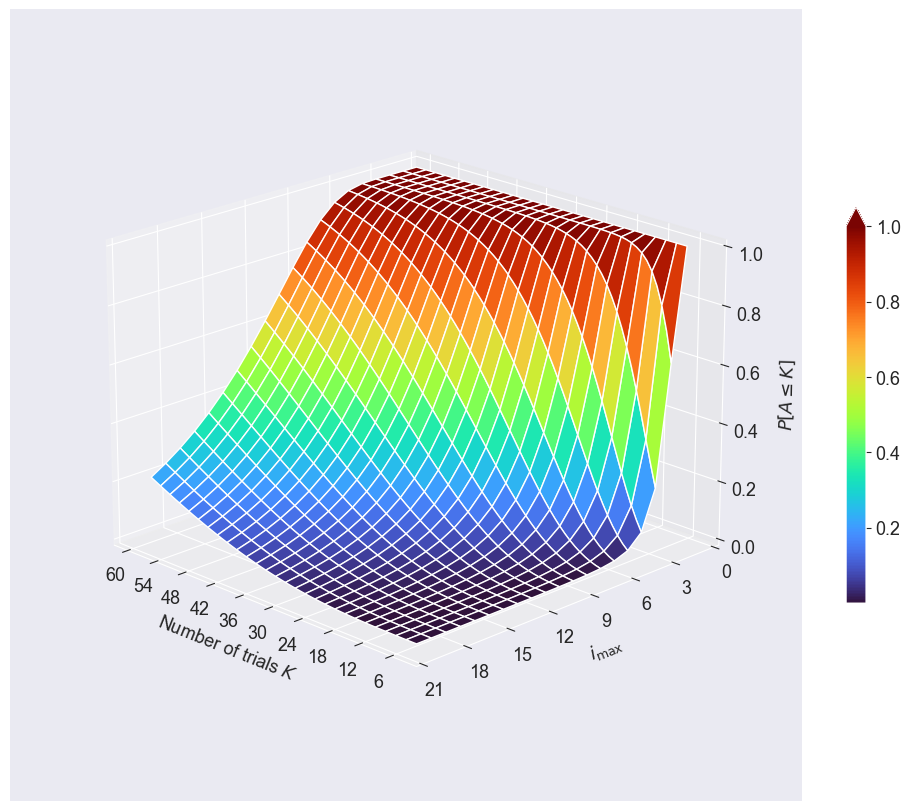

In [16]:
# Parameters
r_max_arr = np.arange(1, 21)  # maximum index of the randomly selected multipath.
n = 5  # number of successful trials needed to congest the link.
trials_arr = np.arange(n, 60)  # number of trials


# CDF matrix using the negative binomial distribution
cdf_matrix = np.zeros(shape=(len(r_max_arr), len(trials_arr)))
for idx, r_max in enumerate(r_max_arr):
    p = 1 / r_max  # probability of a successful trial
    cdf_matrix[idx, :] = nbinom.cdf(trials_arr, n, p)

# 3D Plot
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=20, azim=135)
ax.set_box_aspect(aspect=None, zoom=0.85)
x_axis, y_axis = np.meshgrid(trials_arr, r_max_arr)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"Number of trials $K$", labelpad=10)
ax.set_ylabel(r"$i_\text{max}$", labelpad=10)
ax.set_zlabel(r"$P[A \leq K]$", labelpad=10)
surf = ax.plot_surface(x_axis, y_axis, cdf_matrix, cmap=cm.turbo)
bar = fig.colorbar(surf, ax=ax, shrink=0.5, extend="max")
plt.savefig(f"{IMAGE_DIRECTORY}/4_2_defence_cdf.svg", format="svg")

### Expected Malicious Traffic per Snapshot.
We compute the expected malicious traffic per snapshot against $K$ trials and $i_\text{max}$.

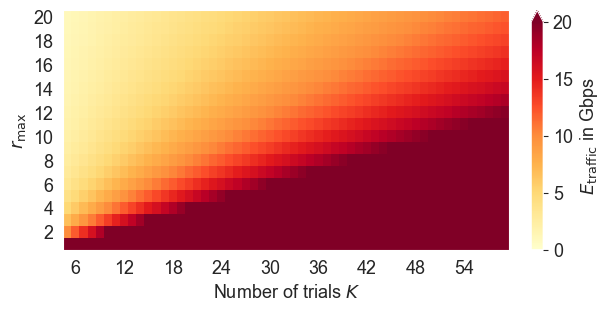

In [17]:
# INITIAL VALUES
r_max_arr = np.arange(1, 21)  # Number of different possible values of r_max.
trials_arr = np.arange(
    5, 60
)  # Number of maliciously executed routes per snapshot. Equivalent to the number of independent trials.

# MEAN given (rmax, K)
mean_matrix = np.zeros(shape=(len(r_max_arr), len(trials_arr)))
for i, r_max in enumerate(r_max_arr):
    p = 1 / r_max
    for j, trials in enumerate(trials_arr):
        mean_matrix[i, j] = (
            binom.mean(trials, p) * 4
        )  # scale to 4 GBits/snapshot per success (4 GBits/snapshot)

# 2D matrix plot.
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
x_axis, y_axis = np.meshgrid(trials_arr, r_max_arr)
cbar = ax.pcolormesh(x_axis, y_axis, mean_matrix, cmap=cm.YlOrRd, vmin=0, vmax=20)
bar = fig.colorbar(cbar, ax=ax, extend="max", label=r"$E_\text{traffic}$ in Gbps")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r"Number of trials $K$")
plt.ylabel(r"$r_\text{max}$")
plt.savefig(f"{IMAGE_DIRECTORY}4_2_defence_mean.svg")
plt.show()

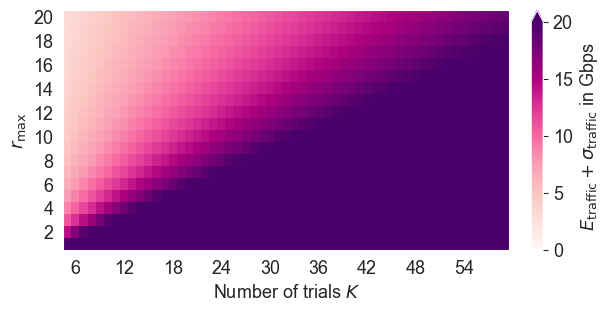

In [18]:
# MEAN + STANDARD DEVIATION given (rmax, K)
# Compute standard deviation
std_matrix = np.zeros(shape=(len(r_max_arr), len(trials_arr)))
for i, r_max in enumerate(r_max_arr):
    p = 1 / r_max
    for j, trials in enumerate(trials_arr):
        std_matrix[i, j] = (
            binom.std(trials, p) * 4
        )  # scale to 4 GBits/snapshot per success (4 GBits/snapshot)

# Plot the data on a 2D matrix.
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
x_axis, y_axis = np.meshgrid(trials_arr, r_max_arr)
cbar = ax.pcolormesh(
    x_axis, y_axis, mean_matrix + std_matrix, cmap=cm.RdPu, vmin=0, vmax=20
)
bar = fig.colorbar(
    cbar,
    ax=ax,
    label=r"$E_\text{traffic} + \sigma_\text{traffic}$ in Gbps",
    extend="max",
)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r"Number of trials $K$")
plt.ylabel(r"$r_\text{max}$")
plt.savefig(f"{IMAGE_DIRECTORY}4_2_defence_std.svg")

# 5.3. Experiments and Evaluation

#### Parameters

In [19]:
# Modify these parameters based on your experimental setup.
IMAX_VALUES = ["OFF", "3", "6", "9"]
REPS = 20  # 100

#### Imports and Plot Settings

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np
import warnings

warnings.filterwarnings(
    "ignore"
)  # Disable long warnings when NaN values are encountered

sns.set(font_scale=0.8)
sns.set_style("darkgrid")

# Enforce consistent color mapping
color_order = ["East", "West", "North", "South", "Theory"]
color_map = dict(zip(color_order, sns.color_palette("bright", 5)))

# Ensure theoretical values, if shown, are always plotted first
order = ["Theory", "East", "West", "North", "South"]

#### Constants

In [21]:
# TODO: remove the directions Attribute.
_SCENARIOS = {
    "Landlocked": {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"],
        "vulnerable" : True,
    },
    "Coastal": {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"],
        "vulnerable" : True,
    },
    "Insular": {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"],
        "vulnerable" : False,
    },
    "Polar": {"type": "Latitudinal", "directions": ["East", "West"],
                      "vulnerable" : True,},
    "Equatorial": {
        "type": "Latitudinal",
        "directions": ["East", "West", "North", "South"],
        "vulnerable" : True,
    },
    "TransOrbital": {
        "type": "Orbital",
        "directions": ["East", "West"],
                "vulnerable" : False,
    },
    "IntraOrbital": {
        "type": "Orbital",
        "directions": ["East", "West", "North", "South"],
        "vulnerable" : True,
    },
}


class ScenarioAttribute(dict):
    def __init__(self, attr: str):
        self.attr = attr

    def __getitem__(self, key: str):
        return _SCENARIOS[key][self.attr]


ALL_DIRECTIONS = ["East", "West", "North", "South"]
DIRECTIONS = ScenarioAttribute("directions")
PALETTES = ScenarioAttribute("palette")
TYPE = ScenarioAttribute("type")
VULNERABLE = ScenarioAttribute("vulnerable")
SCENARIOS = list(_SCENARIOS.keys())

#### Data loading

In [22]:
def load_csv_data(relative_path: str):
    """Load CSV data."""
    path = os.path.join(LOG_DIRECTORY, relative_path)
    assert os.path.isfile(path), f"Path does not exist: {path}"
    return pd.read_csv(path)


def load_json_data(relative_path: str, key: str):
    """Load JSON data."""
    path = os.path.join(LOG_DIRECTORY, relative_path)
    assert os.path.isfile(path), f"Path does not exist: {path}"
    with open(path) as file:
        data = json.load(file)
    return pd.DataFrame(data[key])


# Load attack data
aggregate_data = []
for imax in IMAX_VALUES:
    for scenario in SCENARIOS:
        # if RiDS is enabled, only consider the vulnerable scenarios.
        if imax != "OFF" and not VULNERABLE[scenario]:
            continue
        directions = ALL_DIRECTIONS

        # if RiDS is enabled, only consider the vulnerable directions.
        if imax != "OFF":
            directions = DIRECTIONS[scenario]
        for direction in directions:
            for i in range(0, REPS):
                filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                data = load_csv_data(filename)

                data["scenario"] = scenario
                data["direction"] = direction
                data["imax"] = imax
                aggregate_data.append(data)
attack_df = pd.concat(aggregate_data, axis=0, ignore_index=True)
attack_df.rename(
    columns={
        "FINAL CAPACITY": "traffic",
        "FRAME": "Frame",
        "scenario": "Attribute",
        "direction": "Direction",
    },
    inplace=True,
)
attack_df["traffic"] = 20000 - attack_df["traffic"]
attack_df["traffic"] = attack_df["traffic"] / 1000


# Add theoretical attack data (from Chapter 4)
i_max_arr = list(
    map(int, [i if i != "OFF" else "1" for i in IMAX_VALUES])
)  # Number of different possible values of r_max.
trials = 5
theory_dicts = []
for scenario in SCENARIOS:
    for i_max in i_max_arr:
        p = 1 / i_max
        data = binom.rvs(trials, p, size=100 * 30) * 4
        for data_pt in data:
            theory_dicts.append(
                {
                    "Direction": "Theory",
                    "traffic": data_pt,  # binom.mean(trials, p)*4000,
                    "imax": str(i_max) if i_max != 1 else "OFF",
                    "Attribute": scenario,
                }
            )
attack_df = pd.concat(
    [attack_df, pd.DataFrame(theory_dicts)], axis=0, ignore_index=True
)

# Ensure theoretical data, if shown, comes first.
attack_df["Direction"] = pd.Categorical(
    attack_df["Direction"], categories=order, ordered=True
)

display(attack_df)  # TODO: remove

# Load rtt data
aggregate_data = []
for imax in IMAX_VALUES:
    for scenario in SCENARIOS:

        # if RiDS is enabled, only consider the vulnerable scenarios.
        if imax != "OFF" and not VULNERABLE[scenario]:
            continue
        directions = ALL_DIRECTIONS

        # if RiDS is enabled, only consider the vulnerable directions.
        if imax != "OFF":
            directions = DIRECTIONS[scenario]
        for direction in directions:
            for i in range(0, REPS):
                filename = f"{scenario}_{direction}_{imax}_{i:03d}/rtt.json"
                data = load_json_data(filename, "latencies").explode(
                    "rtt", ignore_index=True
                )
                data["scenario"] = scenario
                data["direction"] = direction
                data["imax"] = imax
                aggregate_data.append(data)
rtt_df = pd.concat(aggregate_data, axis=0, ignore_index=True)
rtt_df.rename(
    columns={"scenario": "Attribute", "direction": "Direction", "frame": "Frame"},
    inplace=True,
)


# Load probability data
probabilities = []
for imax in IMAX_VALUES:
    for scenario in SCENARIOS:
        # if RiDS is enabled, only consider the vulnerable scenarios.
        if imax != "OFF" and not VULNERABLE[scenario]:
            continue
        directions = ALL_DIRECTIONS

        # if RiDS is enabled, only consider the vulnerable directions.
        if imax != "OFF":
            directions = DIRECTIONS[scenario]
        for direction in directions:
            # compute probability
            attempts_df = attack_df.query(
                f"Attribute == '{scenario}' & Direction == '{direction}' & imax == '{imax}'"
            )
            successes_df = attempts_df.query("`traffic` == 20.0")

            temp_data = pd.DataFrame(
                data={
                    "Attribute": [scenario],
                    "Direction": [direction],
                    "Probability": [successes_df.shape[0] / attempts_df.shape[0]],
                    "imax": [imax],
                }
            )
            probabilities.append(temp_data)
probability_df = pd.concat(probabilities, axis=0, ignore_index=True)

# Add theoretical probability data (from Chapter 4)
i_max_arr = list(map(int, [i if i != "OFF" else "1" for i in IMAX_VALUES]))
n = 5
trials = 5
theory_dicts = []
for scenario in SCENARIOS:
    for i_max in i_max_arr:
        theory_dicts.append(
            {
                "Direction": "Theory",
                "Probability": 1 / i_max,  # probability of a successful trial
                "imax": str(i_max) if i_max != 1 else "OFF",
                "Attribute": scenario,
            }
        )
probability_df = pd.concat(
    [probability_df, pd.DataFrame(theory_dicts)], axis=0, ignore_index=True
)
order = ["Theory", "East", "West", "North", "South"]
probability_df["Direction"] = pd.Categorical(
    probability_df["Direction"], categories=order, ordered=True
)


# Get baseline experiments
baseline_rtt_df = rtt_df.query("imax == 'OFF'")
baseline_traffic_df = attack_df.query("imax == 'OFF'")
baseline_probability_df = probability_df.query("imax == 'OFF'")

# Get RiDS experiments
rids_rtt_df = rtt_df.query("Attribute != 'Insular' & Attribute != 'TransOrbital'")
rids_traffic_df = attack_df.query(
    "Attribute != 'Insular' & Attribute != 'TransOrbital'"
)
rids_probability_df = probability_df.query(
    "Attribute != 'Insular' & Attribute != 'TransOrbital'"
)

,Frame,TARGET LINK,ROUTE COUNT,traffic,MALICIOUS TRAFFIC,Attribute,Direction,imax
0,0.0,NaN,0.0,NaN,NaN,Landlocked,East,OFF
1,1.0,530 -> 529,5.0,20.0,20000.0,Landlocked,East,OFF
2,2.0,530 -> 529,5.0,20.0,20000.0,Landlocked,East,OFF
3,3.0,530 -> 529,5.0,20.0,20000.0,Landlocked,East,OFF
4,4.0,530 -> 529,5.0,20.0,20000.0,Landlocked,East,OFF
...,...,...,...,...,...,...,...,...
167635,NaN,NaN,NaN,0.0,NaN,IntraOrbital,Theory,9
167636,NaN,NaN,NaN,4.0,NaN,IntraOrbital,Theory,9
167637,NaN,NaN,NaN,8.0,NaN,IntraOrbital,Theory,9
167638,NaN,NaN,NaN,8.0,NaN,IntraOrbital,Theory,9


## 5.2. Attack Attributes


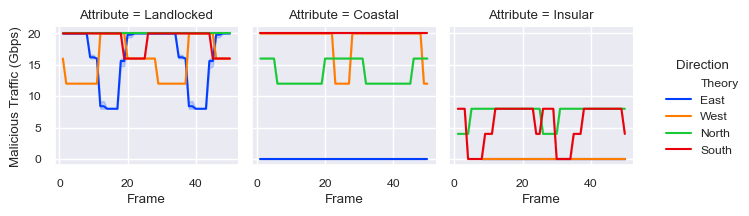

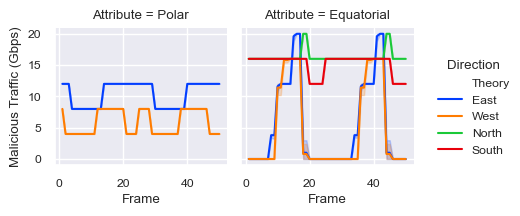

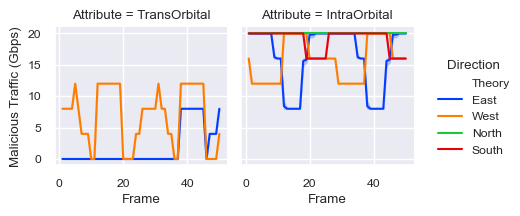

In [23]:
# Geographical
geographical_baseline_traffic_df = baseline_traffic_df.query(
    "Attribute == 'Landlocked' | Attribute == 'Coastal' | Attribute == 'Insular'"
).query("Direction != 'Theory'")
g = sns.FacetGrid(
    geographical_baseline_traffic_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="traffic",
)
g.set_ylabels("Malicious Traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_traffic_geographical.svg")

# Latitudinal
latitudinal_baseline_traffic_df = baseline_traffic_df.query(
    "Attribute == 'Equatorial' | Attribute == 'Polar'"
).query("Direction != 'Theory'")
g = sns.FacetGrid(
    latitudinal_baseline_traffic_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="traffic",
)
g.set_ylabels("Malicious Traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_traffic_latitudinal.svg")

# Orbital
orbital_baseline_traffic_df = baseline_traffic_df.query(
    "Attribute == 'TransOrbital' | Attribute == 'IntraOrbital'"
).query("Direction != 'Theory'")
g = sns.FacetGrid(
    orbital_baseline_traffic_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="traffic",
)
g.set_ylabels("Malicious Traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_traffic_orbital.svg")

----
## 6.1. Baseline performance

### Probability of Congestion by Scenario and Direction: Baseline

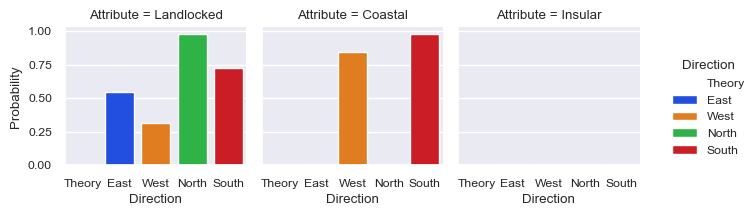

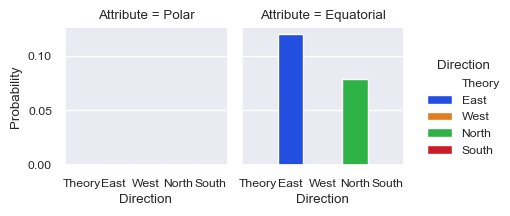

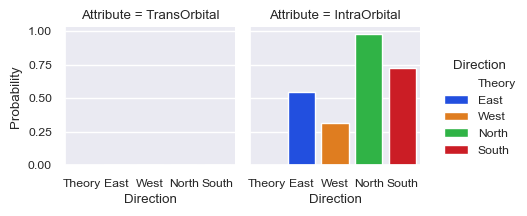

In [24]:
geographical_baseline_probability_df = baseline_probability_df.query(
    "Attribute == 'Landlocked' | Attribute == 'Coastal' | Attribute == 'Insular'"
).query("Direction != 'Theory'")

# Geographical
g = sns.FacetGrid(
    geographical_baseline_probability_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(sns.barplot, x="Direction", y="Probability")
g.add_legend()
plt.savefig("images/baseline_probability_geographical.svg")

# Latitudinal
latitudinal_baseline_probability_df = baseline_probability_df.query(
    "Attribute == 'Equatorial' | Attribute == 'Polar'"
).query("Direction != 'Theory'")
g = sns.FacetGrid(
    latitudinal_baseline_probability_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(sns.barplot, x="Direction", y="Probability")
g.add_legend()
plt.savefig("images/baseline_probability_latitudinal.svg")

# Orbital
orbital_baseline_probability_df = baseline_probability_df.query(
    "Attribute == 'TransOrbital' | Attribute == 'IntraOrbital'"
).query("Direction != 'Theory'")
g = sns.FacetGrid(
    orbital_baseline_probability_df,
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(sns.barplot, x="Direction", y="Probability")
g.add_legend()
plt.savefig("images/baseline_probability_orbital.svg")

with open("baseline_probability.csv", "w") as f:
    baseline_probability_df.query("Direction != 'Theory'").to_csv(f)

### Expected Malicious Traffic by Scenario and Direction: Baseline

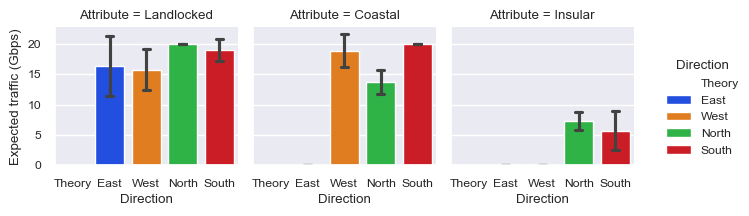

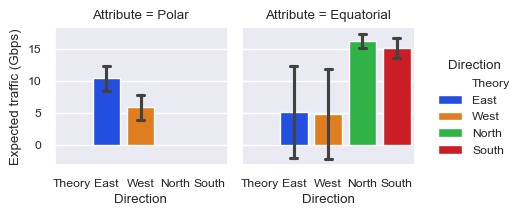

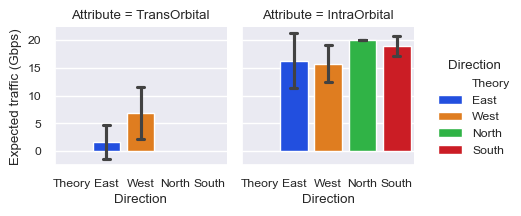

In [25]:
# Geographical
g = sns.FacetGrid(
    baseline_traffic_df.query(
        "Attribute == 'Landlocked' | Attribute == 'Coastal' | Attribute == 'Insular'"
    ).query("Direction != 'Theory'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.barplot,
    x="Direction",
    y="traffic",
    ci="sd",
    capsize=0.2,
    estimator=np.mean,
)
g.set_ylabels("Expected traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_expected_geographical.svg")

# Latitudinal
g = sns.FacetGrid(
    baseline_traffic_df.query("Attribute == 'Polar' | Attribute == 'Equatorial'").query(
        "Direction != 'Theory'"
    ),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.barplot,
    x="Direction",
    y="traffic",
    ci="sd",
    capsize=0.2,
    estimator=np.mean,
)
g.set_ylabels("Expected traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_expected_latitudinal.svg")

# Orbital
g = sns.FacetGrid(
    baseline_traffic_df.query(
        "Attribute == 'TransOrbital' | Attribute == 'IntraOrbital'"
    ).query("Direction != 'Theory'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.barplot,
    x="Direction",
    y="traffic",
    ci="sd",
    capsize=0.2,
    estimator=np.mean,
)
g.set_ylabels("Expected traffic (Gbps)")
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}baseline_expected_orbital.svg")

### Network Latency by Scenario and Direction: Baseline

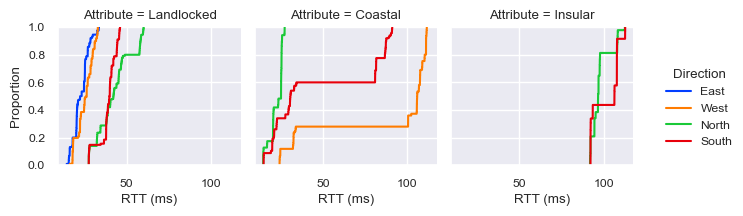

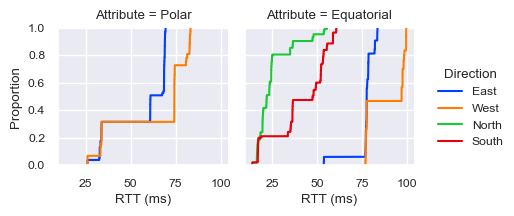

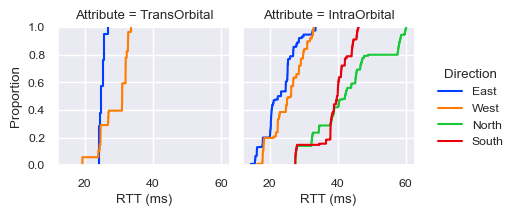

In [26]:
# Geographical
g = sns.FacetGrid(
    baseline_rtt_df.query(
        "Attribute == 'Landlocked' | Attribute == 'Coastal' | Attribute == 'Insular'"
    ),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.ecdfplot,
    x="rtt",
)
g.add_legend()
g.set_xlabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_cdf_geographical.svg")

# Latitudinal
g = sns.FacetGrid(
    baseline_rtt_df.query("Attribute == 'Equatorial' | Attribute == 'Polar'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.ecdfplot,
    x="rtt",
)
g.add_legend()
g.set_xlabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_cdf_latitudinal.svg")

# Orbital
g = sns.FacetGrid(
    baseline_rtt_df.query("Attribute == 'TransOrbital' | Attribute == 'IntraOrbital'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.ecdfplot,
    x="rtt",
)
g.add_legend()
g.set_xlabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_cdf_orbital.svg")

### Network Latency Timeseries: Baseline

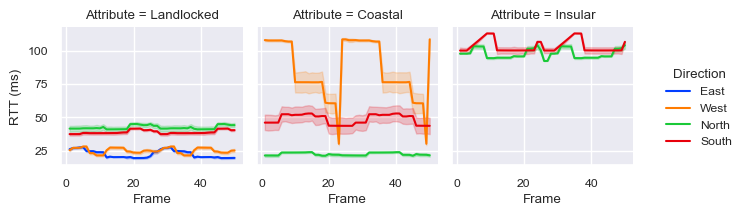

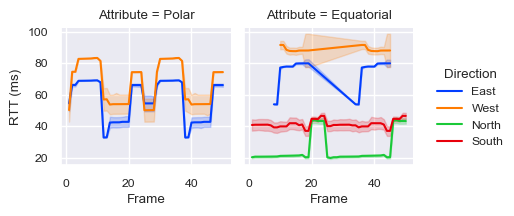

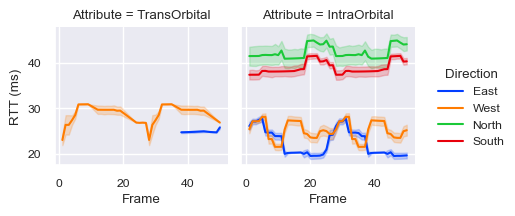

In [27]:
# Geographical
g = sns.FacetGrid(
    baseline_rtt_df.query(
        "Attribute == 'Landlocked' | Attribute == 'Coastal' | Attribute == 'Insular'"
    ),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="rtt",
)
g.add_legend()
g.set_ylabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_timeseries_geographical.svg")

# Latitudinal
g = sns.FacetGrid(
    baseline_rtt_df.query("Attribute == 'Equatorial' | Attribute == 'Polar'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="rtt",
)
g.add_legend()
g.set_ylabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_timeseries_latitudinal.svg")

# Orbital
g = sns.FacetGrid(
    baseline_rtt_df.query("Attribute == 'TransOrbital' | Attribute == 'IntraOrbital'"),
    col="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.lineplot,
    x="Frame",
    y="rtt",
)
g.add_legend()
g.set_ylabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}baseline_rtt_timeseries_orbital.svg")

---

## 6.2. RiDS Performance

#### Congestion Probability by Scenario and Direction: RiDS Enabled

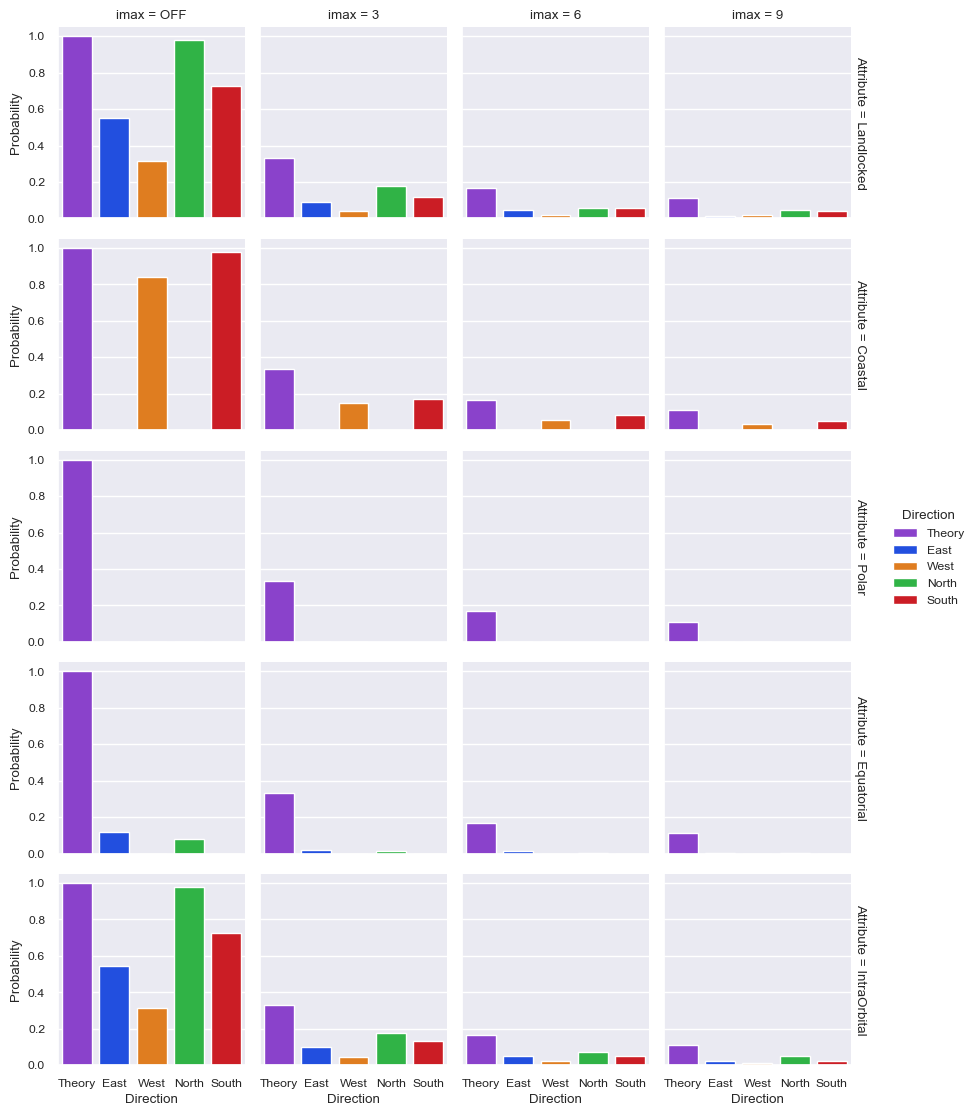

In [28]:
g = sns.FacetGrid(
    rids_probability_df,
    row="Attribute",
    col="imax",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(sns.barplot, x="Direction", y="Probability")
g.add_legend()
g.set_ylabels("Probability")
plt.savefig(f"{IMAGE_DIRECTORY}rids_probability.svg")
plt.show()

### Expected Malicious Traffic by Scenario and Direction: RiDS enabled

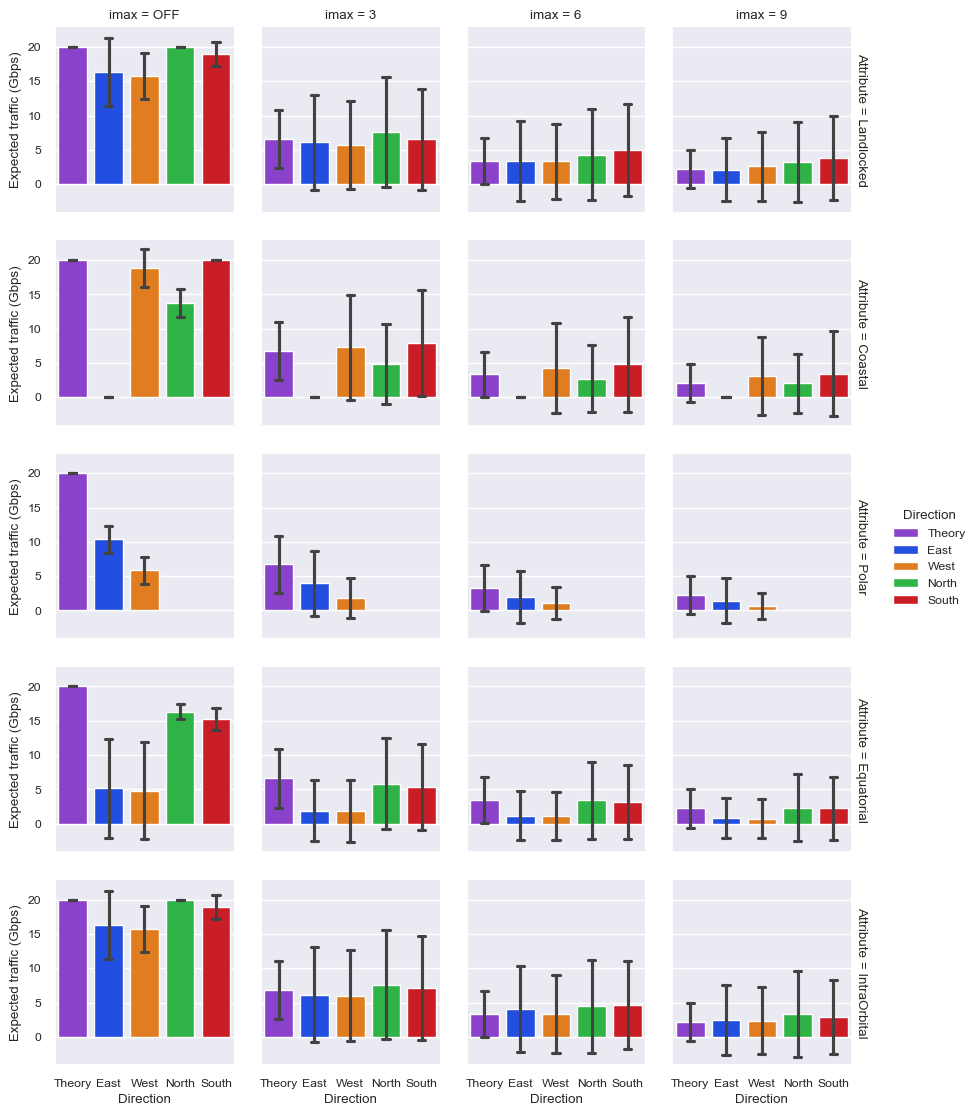

In [29]:
g = sns.FacetGrid(
    rids_traffic_df,
    col="imax",
    hue="Direction",
    row="Attribute",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.barplot,
    x="Direction",
    y="traffic",
    ci="sd",
    capsize=0.2,
    estimator=np.mean,
)

g.set_ylabels("Expected traffic (Gbps)")
g.figure.subplots_adjust(wspace=0.15, hspace=0.15)
g.add_legend()
plt.savefig(f"{IMAGE_DIRECTORY}rids_expected.svg")

#### Network Latency by Scenario and Direction: RiDS enabled

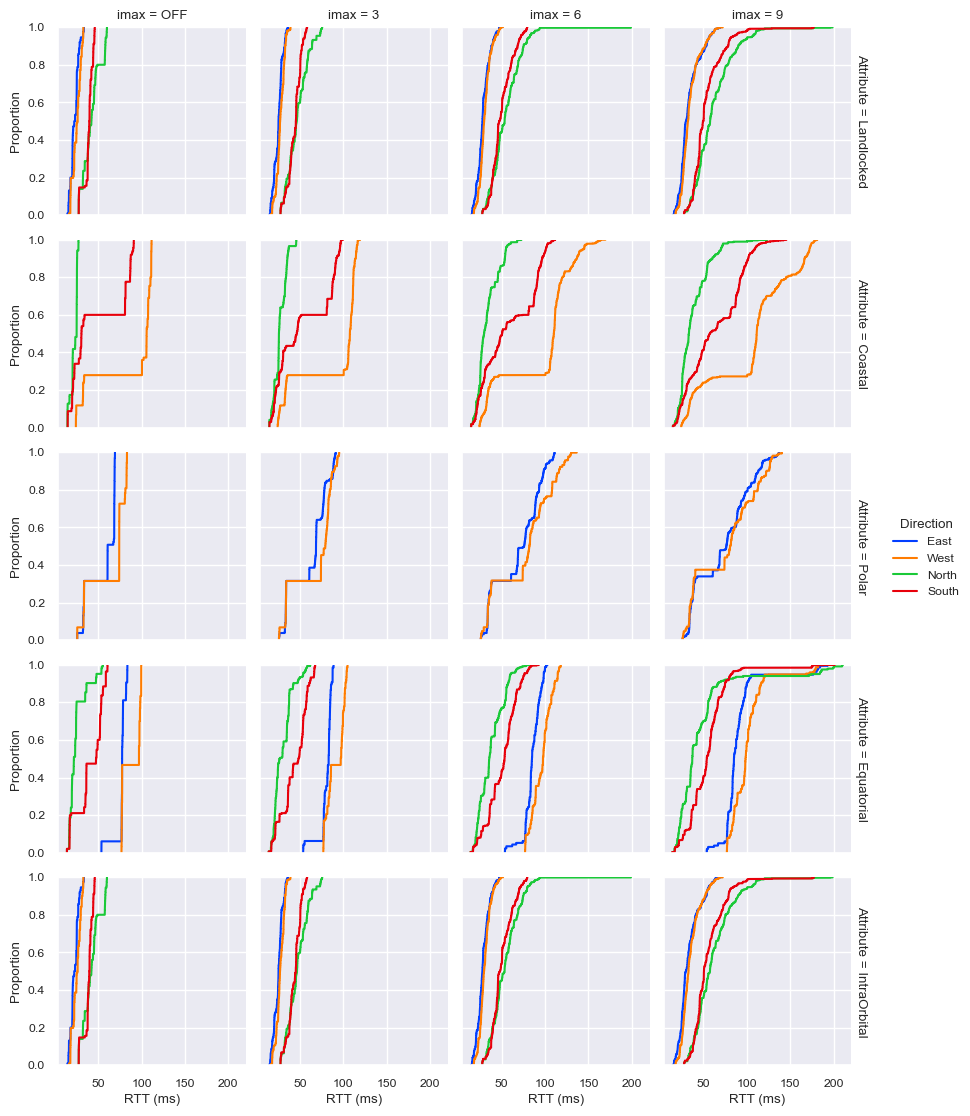

In [30]:
g = sns.FacetGrid(
    rids_rtt_df,
    col="imax",
    row="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(
    sns.ecdfplot,
    x="rtt",
)
g.add_legend()
g.set_xlabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}rids_rtt_cdf.svg")

### Network Latency Timeseries: RiDS Enabled

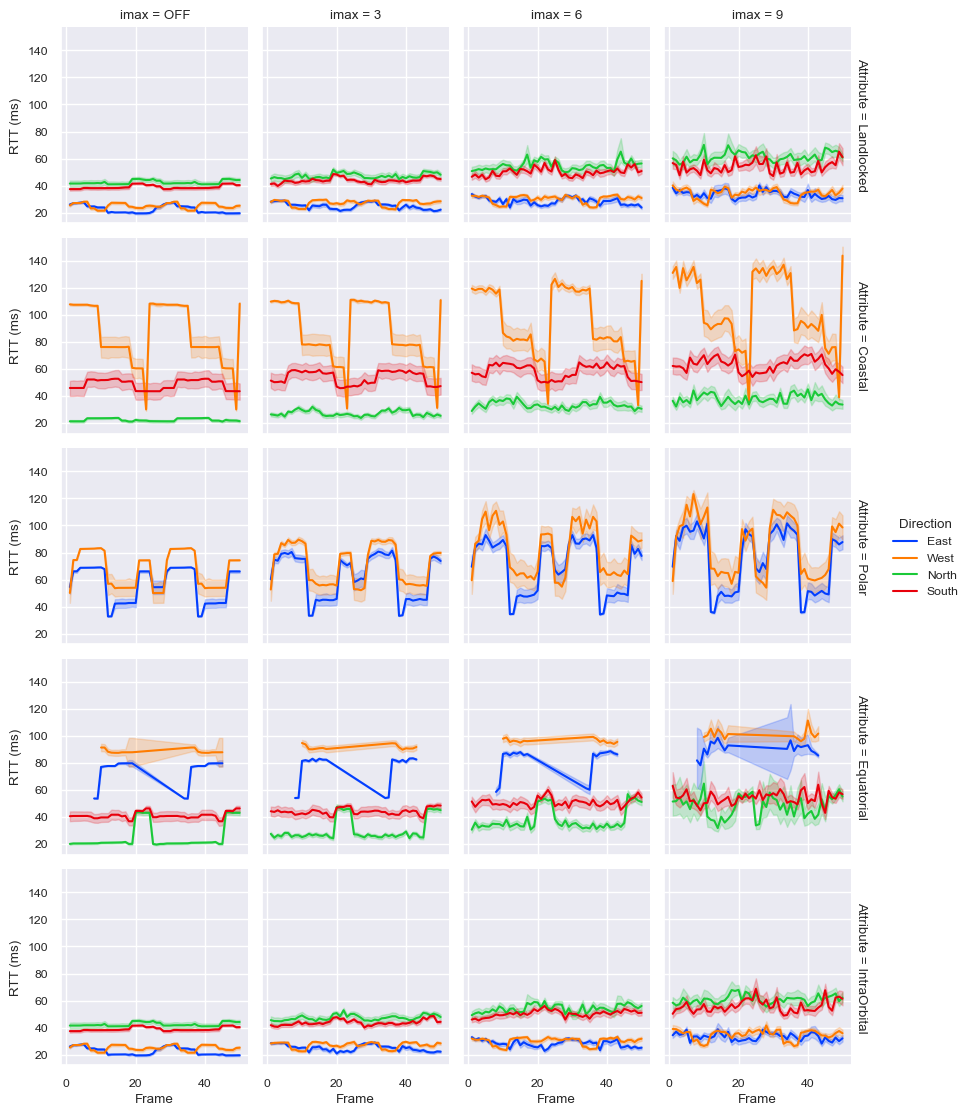

In [31]:
g = sns.FacetGrid(
    rids_rtt_df,
    col="imax",
    row="Attribute",
    hue="Direction",
    margin_titles=True,
    height=2.25,
    palette=color_map,
)
g.map_dataframe(sns.lineplot, x="Frame", y="rtt")
g.add_legend()
g.set_ylabels("RTT (ms)")
plt.savefig(f"{IMAGE_DIRECTORY}rids_rtt_timeseries.svg")